In [1]:
import argparse
import os
import random

import numpy as np
import numpy.matlib

import matplotlib.pyplot as plt
import pickle
from collections import Counter

## Dataset overview

In this problem we are building 15-way multi-class classifiers for a fruit classification task. The training and validation sets are stored in the .pkl files provided. See the hw5.pdf file we have provided for details.

In each dataset, we provide the following:
- 'images': the raw RGB images
- 'feats': 15 dimensional condensed representations of each image (that were precomputed by using a pretrained vision transformer + PCA)
- 'labels': an integer value between 0 and 14. The integer to class mapping is provided below in the variable 'idx_to_class'.

We first create a simple python dictionary that maps integers to textual class labels that can be useful for debugging.

In [2]:
idx_to_class = {0: 'Apple', 1: 'Banana', 2: 'Carambola', 3: 'Guava', 4: 'Kiwi', 5: 'Mango', 6: 'Orange', 7: 'Peach', 8: 'Pear', 9: 'Persimmon', 10: 'Pitaya', 11: 'Plum', 12: 'Pomegranate', 13: 'Tomatoes', 14: 'Muskmelon'}
target_names = list(idx_to_class.values())
print(idx_to_class)

{0: 'Apple', 1: 'Banana', 2: 'Carambola', 3: 'Guava', 4: 'Kiwi', 5: 'Mango', 6: 'Orange', 7: 'Peach', 8: 'Pear', 9: 'Persimmon', 10: 'Pitaya', 11: 'Plum', 12: 'Pomegranate', 13: 'Tomatoes', 14: 'Muskmelon'}


Next, we load the .pkl files that load as python dictionaries.

In [2]:
with open('train.pkl', 'rb') as f:
    train_dataset = pickle.load(f)

In [3]:
with open('val.pkl', 'rb') as f:
    val_dataset = pickle.load(f)

In [4]:
with open('test_data.pkl','rb') as f:
    test_dataset = pickle.load(f)

NameError: name 'val_dataset' is not defined

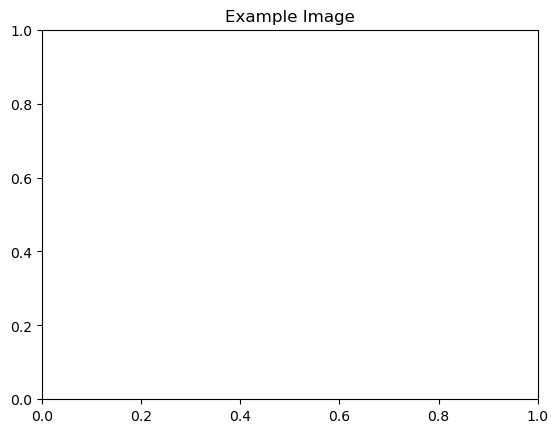

In [6]:
# We can plot the images this way. This will be quite useful for debugging.
plt.figure()
plt.title('Example Image')
plt.imshow(val_dataset['images'][2005])
plt.show()

In [6]:
print("Examples Features shape:", train_dataset['feats'][0].shape)

Examples Features shape: (15,)


In [7]:
print("Example image label:", idx_to_class[val_dataset['labels'][2114]])

Example image label: Orange


In [8]:
train_dataset.keys()

dict_keys(['images', 'feats', 'labels'])

In [9]:
val_dataset.keys()

dict_keys(['images', 'feats', 'labels'])

In [5]:
# Train Dataset
X_train = train_dataset['feats']
y_train = train_dataset['labels']

# Validation Dataset
X_valid = val_dataset['feats']
y_valid = val_dataset['labels']


In [6]:
X_train, y_train, X_valid,y_valid = np.array(X_train), np.array(y_train), np.array(X_valid), np.array(y_valid)

## Part 2(a): Logistic Regression

Implement Logistic Regression from scratch and report your classifier's accuracy on the training and validation sets. **You should use your implementation from prior homeworks and turn it in again with updates, if any.**

# TODO: Implement multinomial logistic regression
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None
        
    def fit(self, X, y):
        # Initialize parameters
        num_samples, num_features = X.shape
        num_classes = len(np.unique(y))
        self.weights = np.zeros((num_classes, num_features))
        self.bias = np.zeros((1, num_classes))
        
        # One-hot encode the labels
        y_onehot = np.zeros((num_samples, num_classes))
        y_onehot[np.arange(num_samples), y] = 1
        
        # Optimization with gradient descent
        for i in range(self.num_iterations):
            z = np.dot(X, self.weights.T) + self.bias
            A = self.softmax(z)
            loss = self.cross_entropy_loss(y_onehot, A)
            dz = A - y_onehot
            dw = np.dot(dz.T, X)
            db = np.sum(dz, axis=0, keepdims=True)
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            if i % 100 == 0:
                print(f"Loss after iteration {i}: {loss}")
                
    def predict(self, X):
        z = np.dot(X, self.weights.T) + self.bias
        A = self.softmax(z)
        return np.argmax(A, axis=1)
    
    def softmax(self, z):
        return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)
    
    def cross_entropy_loss(self, y, A):
        num_samples = y.shape[0]
        loss = -1/num_samples * np.sum(y * np.log(A))
        return loss


# TODO: Report accuracy on training and validation sets
log = LogisticRegression()
log.fit(X_train, y_train)
y_pred_train = log.predict(X_train)
accuracy = np.mean(y_pred_train == y_train) * 100
print(f"Training Accuracy of Logistic Regression: {accuracy}")
y_pred_valid = log.predict(X_valid)
accuracy = np.mean(y_pred_valid == y_valid) * 100
print(f"Validation Accuracy of Logistic Regression: {accuracy}")

def repeated_label(y):
        counter = Counter(y)
        repeat = counter.most_common(1)[0][0]
        return repeat

## Part 2(b): Random Forest/GBDT 

Implement a random forest or GBDT from scratch and report your classifier's accuracy on the training and validation sets. **You should use your implementation from prior homeworks and turn it in again with updates, if any.**

def new_sample(X, y):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples, n_samples, replace=True)
    return X[idxs], y[idxs]

class TreeNode:
    '''
    Data structure that are used for storing a node on a tree.
    
    A tree is presented by a set of nested TreeNodes,
    with one TreeNode pointing two child TreeNodes,
    until a tree leaf is reached.
    
    A node on a tree can be either a leaf node or a non-leaf node.
    '''
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def forward(self):
        return self.value is not None

class Tree:
    '''
    Class of a single decision tree

    Parameters:
        n_threads: The number of threads used for fitting and predicting.
        max_depth: The maximum depth of the tree.
        min_sample_split: The minimum number of samples required to further split a node.
    '''
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None
    
    def path(self, x, node):
        if node.forward():
            return node.value

        if x[node.feature] <= node.threshold:
            return self.path(x, node.left)
        return self.path(x, node.right)
    
    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self.construct_tree(X, y)

    def predict(self, X):
        return np.array([self.path(x, self.root) for x in X])

    def construct_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        if (depth >= self.max_depth
                or n_labels == 1
                or n_samples < self.min_samples_split):
            leaf_value = repeated_label(y)
            return TreeNode(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self.find_decision_rule(X, y, feat_idxs)
        
        # grow the children that result from the split
        left_idxs, right_idxs = self._best_split(X[:, best_feat], best_thresh)
        left = self.construct_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self.construct_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return TreeNode(best_feat, best_thresh, left, right)

    def _best_split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs
    
    def find_decision_rule(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def entropy(self,y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])
    
    def _information_gain(self, y, X_column, split_thresh):
        parent_entropy = self.entropy(y)
        left_idxs, right_idxs = self._best_split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self.entropy(y[left_idxs]), self.entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

class RandomForest:
    
    def __init__(self, n_trees=10, min_samples_split=2,
                 max_depth=100, n_feats=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.trees = []

    def fit(self, X_train, y_train):
        self.trees = []
        for _ in range(self.n_trees):
            tree = Tree(min_samples_split=self.min_samples_split,
                max_depth=self.max_depth, n_feats=self.n_feats)
            X_samp, y_samp = new_sample(X_train, y_train)
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [repeated_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)

# TODO: Report accuracy on training and validation sets
# Reshape features if necessary

rf = RandomForest(n_trees = 5)
rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
accuracy = np.mean(y_pred_train == y_train) * 100
print(f"Training Accuracy of Random Forest: {accuracy}")
y_pred_valid = rf.predict(X_valid)
accuracy = np.mean(y_pred_valid == y_valid) * 100
print(f"Validation Accuracy of Random Forest: {accuracy}")


## Part 2(c): K-NN

Implement a K-NN classifier from scratch and report your classifier's accuracy on the training and validation sets. **You should use your implementation from prior homeworks and turn it in again with updates, if any.**

In [ ]:
# TODO: Implement a kNN classifier
class KNN:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = np.zeros(X.shape[0], dtype=int)
        for i in range(X.shape[0]):
            distances = np.sqrt(np.sum((self.X_train - X[i])**2, axis=1))
            nearest_neighbors = self.y_train[np.argsort(distances)[:self.k]]
            y_pred[i] = np.bincount(nearest_neighbors).argmax()
        return y_pred

In [ ]:
#TODO: Report accuracy on training and validation sets
knn = KNN(k=5)
knn.fit(X_train, y_train)
y_pred_train = knn.predict(X_train)
accuracy = np.mean(y_pred_train == y_train) * 100
print(f"Training Accuracy of KNN: {accuracy}")
y_pred_valid = knn.predict(X_valid)
accuracy = np.mean(y_pred_valid == y_valid) * 100
print(f"Validation Accuracy of KNN: {accuracy}")

## Part 2(d): MLP

Train an MLP classifier and report your classifier's accuracy on the training and validation sets. **You are allowed to use sklearn.neural_network.MLPClassifier for this section.** Make sure to run in all code you used to train and test your MLP classifier. See https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html for details.

In [ ]:
from sklearn.neural_network import MLPClassifier

# TODO: Train an MLPClassifier and report training and validation set accuracies
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
y_pred_train = mlp.predict(X_train)
accuracy = np.mean(y_pred_train == y_train) * 100
print(f"Training Accuracy of MLP: {accuracy}")
y_pred_valid = mlp.predict(X_valid)
accuracy = np.mean(y_pred_valid == y_valid) * 100
print(f"Validation Accuracy of MLP: {accuracy}")

## Part 2(f): Bakeoff: Choose the best Classifier

For this section, you are free to use a classifier of your choice (you are allowed to use any libraries of your choice). You are also free to use the training and validation sets in any way you choose i.e. you can merge them and perform k-fold cross validation. <br>

To evaluate your classifier, we will on March 15th provide you with a pickle file ('test.pkl') that will be in the same format as the 'train.pkl' and 'val.pkl' but **will not contain the labels**. You will need to generate predictions for each of the inputs we provide in 'test.pkl' in a text file. <br>

For your submission, you will need to provide us with a  **test_predictions.txt** file containing the class predictions of your classifier. We will compute the accuracy of the predictions you provide for your evaluation.

In [7]:
# Extra libraries
import pandas as pd
#Importing Models and metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, make_scorer, plot_confusion_matrix, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier

In [8]:
# Joining both train and valid sets for higher data
X_train = np.append(X_train, X_valid, axis=0)
y_train = np.append(y_train, y_valid)
X_train.shape, y_train.shape

((11992, 15), (11992,))

In [9]:
label_counts = np.bincount(y_train)
label_counts

array([1977,  533,  361, 3299, 1451,  687,  526,  464,  517,  342,  410,
        411,  347,  356,  311])

We will use `weighted` averaging for metrics as the classes are imbalanced

 k-fold cross validation splits the train and validation sets randomly but sometimes it may lead to poor train set. So insead we will use stratified k-fold.

In [ ]:
kfold = StratifiedKFold(n_splits=10)

: 

: 

### KNN

In [32]:
mod_knn = KNeighborsClassifier()
grid_knn = GridSearchCV(
    estimator = mod_knn,
    param_grid={'n_neighbors': [1,3,5,7,9,11,13,15]},
    cv = kfold,
    scoring = {'Accuracy':make_scorer(accuracy_score),'Precision':make_scorer(precision_score, average='weighted'), 'Recall':make_scorer(recall_score, average='weighted'),'F1-score':make_scorer(f1_score, average='weighted')},
    refit = 'Accuracy' #Inorder to rank the output
)
grid_knn.fit(X_train, y_train)
mod_knn_scores = pd.DataFrame(grid_knn.cv_results_)
print(grid_knn.best_params_)
print(grid_knn.best_score_)
mod_knn_scores

{'n_neighbors': 1}
0.9395431609674729


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,...,split3_test_F1-score,split4_test_F1-score,split5_test_F1-score,split6_test_F1-score,split7_test_F1-score,split8_test_F1-score,split9_test_F1-score,mean_test_F1-score,std_test_F1-score,rank_test_F1-score
0,0.009989,0.003053,0.030674,0.002365,1,{'n_neighbors': 1},0.936667,0.940833,0.934946,0.939950,...,0.939766,0.941762,0.935291,0.944234,0.934574,0.935906,0.948806,0.939065,0.004546,1
1,0.009726,0.001629,0.043112,0.004051,3,{'n_neighbors': 3},0.932500,0.933333,0.921601,0.935780,...,0.934889,0.942907,0.933738,0.933358,0.935449,0.936947,0.943273,0.934478,0.006159,2
2,0.010041,0.000445,0.050449,0.001433,5,{'n_neighbors': 5},0.935833,0.934167,0.909925,0.929108,...,0.927426,0.936659,0.927576,0.928479,0.938587,0.932821,0.945490,0.931312,0.009341,3
3,0.009260,0.000471,0.049866,0.001498,7,{'n_neighbors': 7},0.935000,0.932500,0.914929,0.935780,...,0.934121,0.930647,0.925041,0.922338,0.935243,0.930110,0.938044,0.929407,0.006980,4
4,0.008601,0.000215,0.050881,0.000723,9,{'n_neighbors': 9},0.930833,0.928333,0.914095,0.931610,...,0.929628,0.932890,0.931065,0.917426,0.936357,0.928465,0.933534,0.927830,0.007011,5
5,0.008573,0.000250,0.052569,0.001005,11,{'n_neighbors': 11},0.928333,0.929167,0.904921,0.925771,...,0.923615,0.926945,0.920586,0.917915,0.937499,0.930131,0.924012,0.923839,0.008670,6
6,0.008928,0.000191,0.057068,0.003178,13,{'n_neighbors': 13},0.925833,0.925833,0.900751,0.923269,...,0.920740,0.927233,0.917123,0.909333,0.932312,0.927562,0.926979,0.920807,0.009644,7
7,0.009705,0.000564,0.061759,0.002652,15,{'n_neighbors': 15},0.926667,0.925000,0.901585,0.922435,...,0.920182,0.926511,0.917320,0.908534,0.926769,0.921623,0.924703,0.919347,0.008548,8


### SVM

In [41]:
svm2 = SVC(kernel='rbf')
gridsvm = GridSearchCV(
    estimator = svm2,
    param_grid={'C':[10,20,30,40,50,60, 70, 80, 90, 100]},
    cv = kfold,
    scoring = {'Accuracy':make_scorer(accuracy_score),'Precision':make_scorer(precision_score, average='weighted'), 'Recall':make_scorer(recall_score, average='weighted'),'F1-score':make_scorer(f1_score, average='weighted')},
    refit = 'Accuracy', #Inorder to rank the output
)
gridsvm.fit(X_train, y_train)
modsvm_scores = pd.DataFrame(gridsvm.cv_results_)
print(gridsvm.best_params_)
print(gridsvm.best_score_)
modsvm_scores

{'C': 40}
0.9652267167083679


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,...,split3_test_F1-score,split4_test_F1-score,split5_test_F1-score,split6_test_F1-score,split7_test_F1-score,split8_test_F1-score,split9_test_F1-score,mean_test_F1-score,std_test_F1-score,rank_test_F1-score
0,0.338777,0.009018,0.106316,0.002395,10,{'C': 10},0.962500,0.960833,0.964971,0.964971,...,0.964683,0.957050,0.961796,0.959334,0.966573,0.964661,0.965099,0.962741,0.002863,10
1,0.347353,0.011198,0.105709,0.006329,20,{'C': 20},0.961667,0.965833,0.962469,0.964971,...,0.964847,0.965534,0.960891,0.959966,0.968984,0.967211,0.969071,0.964648,0.003102,3
2,0.373390,0.026872,0.108097,0.006941,30,{'C': 30},0.965833,0.965833,0.961635,0.967473,...,0.967337,0.968066,0.957335,0.962499,0.966319,0.967178,0.966667,0.964897,0.003163,2
3,0.373816,0.033203,0.103540,0.005560,40,{'C': 40},0.965000,0.966667,0.960801,0.968307,...,0.968168,0.968027,0.959128,0.961560,0.967305,0.968020,0.965761,0.965085,0.003136,1
4,0.349398,0.009538,0.101916,0.003950,50,{'C': 50},0.965000,0.965833,0.958299,0.967473,...,0.967385,0.966359,0.956418,0.959151,0.965608,0.967136,0.967376,0.963897,0.003945,4
5,0.368553,0.022036,0.105720,0.006259,60,{'C': 60},0.965833,0.966667,0.957465,0.966639,...,0.966527,0.964693,0.955723,0.957541,0.963858,0.967115,0.967357,0.963324,0.004283,7
6,0.370797,0.025769,0.104207,0.005836,70,{'C': 70},0.965000,0.965833,0.956631,0.968307,...,0.968188,0.964693,0.956571,0.955940,0.963040,0.965440,0.968226,0.963020,0.004502,9
7,0.355661,0.017624,0.099381,0.002473,80,{'C': 80},0.965833,0.965833,0.957465,0.967473,...,0.967380,0.963836,0.957416,0.956670,0.963810,0.966320,0.967433,0.963257,0.004079,8
8,0.351023,0.002814,0.099132,0.002052,90,{'C': 90},0.965833,0.965000,0.958299,0.968307,...,0.968188,0.963836,0.958323,0.957459,0.963810,0.966374,0.967418,0.963514,0.003762,6
9,0.373175,0.025499,0.103286,0.005787,100,{'C': 100},0.966667,0.964167,0.957465,0.968307,...,0.968188,0.964693,0.958323,0.957459,0.963947,0.966374,0.968280,0.963613,0.004023,5


In [39]:
mod_svm = SVC()
grid_svm = GridSearchCV(
    estimator = mod_svm,
    param_grid={'kernel': ['rbf'], 'C':[0.1,1,10,30,50,100]},
    cv = kfold,
    scoring = {'Accuracy':make_scorer(accuracy_score),'Precision':make_scorer(precision_score, average='weighted'), 'Recall':make_scorer(recall_score, average='weighted'),'F1-score':make_scorer(f1_score, average='weighted')},
    refit = 'Accuracy', #Inorder to rank the output
)
grid_svm.fit(X_train, y_train)
mod_svm_scores = pd.DataFrame(grid_svm.cv_results_)
print(grid_svm.best_params_)
print(grid_svm.best_score_)
mod_svm_scores

{'C': 30, 'kernel': 'rbf'}
0.9650599110369751


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,...,split3_test_F1-score,split4_test_F1-score,split5_test_F1-score,split6_test_F1-score,split7_test_F1-score,split8_test_F1-score,split9_test_F1-score,mean_test_F1-score,std_test_F1-score,rank_test_F1-score
0,0.848301,0.030550,0.247105,0.007256,0.1,rbf,"{'C': 0.1, 'kernel': 'rbf'}",0.900000,0.903333,0.879900,...,0.904059,0.902190,0.899466,0.892729,0.900537,0.879513,0.904838,0.895284,0.010004,6
1,0.400596,0.006615,0.147288,0.006505,1,rbf,"{'C': 1, 'kernel': 'rbf'}",0.947500,0.945833,0.938282,...,0.954666,0.947076,0.950700,0.937462,0.956409,0.946897,0.957063,0.948057,0.006508,5
2,0.342081,0.005797,0.108109,0.002969,10,rbf,"{'C': 10, 'kernel': 'rbf'}",0.962500,0.960833,0.964971,...,0.964683,0.957050,0.961796,0.959334,0.966573,0.964661,0.965099,0.962741,0.002863,4
3,0.339932,0.006264,0.100335,0.001519,30,rbf,"{'C': 30, 'kernel': 'rbf'}",0.965833,0.965833,0.961635,...,0.967337,0.968066,0.957335,0.962499,0.966319,0.967178,0.966667,0.964897,0.003163,1
4,0.345567,0.006965,0.100962,0.004283,50,rbf,"{'C': 50, 'kernel': 'rbf'}",0.965000,0.965833,0.958299,...,0.967385,0.966359,0.956418,0.959151,0.965608,0.967136,0.967376,0.963897,0.003945,2
5,0.360294,0.009485,0.098695,0.002579,100,rbf,"{'C': 100, 'kernel': 'rbf'}",0.966667,0.964167,0.957465,...,0.968188,0.964693,0.958323,0.957459,0.963947,0.966374,0.968280,0.963613,0.004023,3


In [34]:
mod_svm.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

### Ensemble

#### Random Forest

In [16]:
mod_rf = RandomForestClassifier()
grid_rf = GridSearchCV(
    estimator = mod_rf,
    param_grid={'n_estimators': [50, 100, 200]},
    cv = kfold,
    scoring = {'Accuracy':make_scorer(accuracy_score),'Precision':make_scorer(precision_score, average='weighted'), 'Recall':make_scorer(recall_score, average='weighted'),'F1-score':make_scorer(f1_score, average='weighted')},
    refit = 'Accuracy', #Inorder to rank the output
)
grid_rf.fit(X_train, y_train)
mod_rf_scores = pd.DataFrame(grid_rf.cv_results_)
print(grid_rf.best_params_)
print(grid_rf.best_score_)
mod_rf_scores

{'n_estimators': 100}
0.9310371837642479


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,...,split3_test_F1-score,split4_test_F1-score,split5_test_F1-score,split6_test_F1-score,split7_test_F1-score,split8_test_F1-score,split9_test_F1-score,mean_test_F1-score,std_test_F1-score,rank_test_F1-score
0,1.045044,0.069567,0.013473,0.002264,50,{'n_estimators': 50},0.926667,0.919167,0.919933,0.929942,...,0.927750,0.927144,0.931403,0.924984,0.939610,0.920124,0.925614,0.925688,0.006363,3
1,1.905382,0.020884,0.020505,0.000344,100,{'n_estimators': 100},0.931667,0.932500,0.920767,0.934112,...,0.932768,0.931172,0.927310,0.934149,0.933354,0.923976,0.932486,0.929552,0.004406,1
2,3.893165,0.047785,0.041102,0.001603,200,{'n_estimators': 200},0.932500,0.919167,0.919933,0.932444,...,0.930592,0.933083,0.929063,0.927194,0.933083,0.926641,0.937060,0.928378,0.006117,2


#### Gradient Boost

In [19]:
gbdt = GradientBoostingClassifier()
gbdt.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [20]:
mod_gbdt = GradientBoostingClassifier()
grid_gbdt = GridSearchCV(
    estimator = mod_gbdt,
    param_grid={'n_estimators': [50, 100, 200]},
    cv = kfold,
    scoring = {'Accuracy':make_scorer(accuracy_score),'Precision':make_scorer(precision_score, average='weighted'), 'Recall':make_scorer(recall_score, average='weighted'),'F1-score':make_scorer(f1_score, average='weighted')},
    refit = 'Accuracy', #Inorder to rank the output
)
grid_gbdt.fit(X_train, y_train)
mod_gbdt_scores = pd.DataFrame(grid_gbdt.cv_results_)
print(grid_gbdt.best_params_)
print(grid_gbdt.best_score_)
mod_gbdt_scores

{'n_estimators': 200}
0.9217819710870169


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,...,split3_test_F1-score,split4_test_F1-score,split5_test_F1-score,split6_test_F1-score,split7_test_F1-score,split8_test_F1-score,split9_test_F1-score,mean_test_F1-score,std_test_F1-score,rank_test_F1-score
0,26.812142,0.378932,0.011452,0.000606,50,{'n_estimators': 50},0.8875,0.887500,0.875730,0.907423,...,0.905325,0.910404,0.897376,0.895230,0.896067,0.880223,0.902205,0.893132,0.011117,3
1,53.225979,0.597779,0.019805,0.001230,100,{'n_estimators': 100},0.9050,0.901667,0.899083,0.920767,...,0.919412,0.918038,0.916916,0.910883,0.915456,0.896440,0.916665,0.909747,0.008430,2
2,103.902350,1.773949,0.033473,0.001021,200,{'n_estimators': 200},0.9175,0.916667,0.912427,0.925771,...,0.924611,0.929323,0.929352,0.922590,0.924953,0.907418,0.925958,0.921012,0.007037,1


#### XG-Boost

In [23]:
xgb = XGBClassifier()
xgb.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [27]:
mod_xgb = XGBClassifier()
grid_xgb = GridSearchCV(
    estimator = mod_xgb,
    param_grid={'n_estimators':[100,200,300], 'learning_rate':[0.1,0.01,0.05,1] },
    cv = kfold,
    scoring = {'Accuracy':make_scorer(accuracy_score),'Precision':make_scorer(precision_score, average='weighted'), 'Recall':make_scorer(recall_score, average='weighted'),'F1-score':make_scorer(f1_score, average='weighted')},
    refit = 'Accuracy', #Inorder to rank the output
)
grid_xgb.fit(X_train, y_train)
mod_xgb_scores = pd.DataFrame(grid_xgb.cv_results_)
print(grid_xgb.best_params_)
print(grid_xgb.best_score_)
mod_xgb_scores

{'learning_rate': 0.1, 'n_estimators': 300}
0.9411276063386154


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,...,split3_test_F1-score,split4_test_F1-score,split5_test_F1-score,split6_test_F1-score,split7_test_F1-score,split8_test_F1-score,split9_test_F1-score,mean_test_F1-score,std_test_F1-score,rank_test_F1-score
0,9.749584,1.369605,0.008659,0.002881,0.1,100,"{'learning_rate': 0.1, 'n_estimators': 100}",0.926667,0.934167,0.925771,...,0.940471,0.934489,0.937850,0.929827,0.933560,0.920579,0.932533,0.931422,0.005699,5
1,15.693647,2.052870,0.011193,0.002080,0.1,200,"{'learning_rate': 0.1, 'n_estimators': 200}",0.931667,0.943333,0.931610,...,0.946901,0.939638,0.941295,0.935700,0.945486,0.935200,0.936567,0.938604,0.005210,2
2,20.717268,2.416299,0.013510,0.001459,0.1,300,"{'learning_rate': 0.1, 'n_estimators': 300}",0.934167,0.945833,0.933278,...,0.951353,0.943032,0.944592,0.937368,0.942877,0.935102,0.940039,0.940637,0.005560,1
3,10.164219,0.556875,0.008406,0.001552,0.01,100,"{'learning_rate': 0.01, 'n_estimators': 100}",0.872500,0.878333,0.869058,...,0.889485,0.889441,0.887566,0.883767,0.884376,0.871919,0.876715,0.879477,0.008081,12
4,20.488621,0.550093,0.010881,0.002230,0.01,200,"{'learning_rate': 0.01, 'n_estimators': 200}",0.891667,0.901667,0.881568,...,0.898609,0.899444,0.910552,0.897367,0.896992,0.885774,0.888157,0.894616,0.008323,11
5,31.430641,2.490333,0.013134,0.003202,0.01,300,"{'learning_rate': 0.01, 'n_estimators': 300}",0.903333,0.908333,0.884904,...,0.912566,0.914786,0.913461,0.912327,0.906495,0.892967,0.902510,0.904599,0.009635,10
6,9.998370,1.051811,0.007056,0.001377,0.05,100,"{'learning_rate': 0.05, 'n_estimators': 100}",0.915000,0.919167,0.901585,...,0.926229,0.925890,0.922470,0.921687,0.919162,0.902062,0.918139,0.916747,0.008526,9
7,21.184623,5.477631,0.012676,0.003085,0.05,200,"{'learning_rate': 0.05, 'n_estimators': 200}",0.929167,0.932500,0.930776,...,0.941251,0.934507,0.933637,0.929787,0.935202,0.918816,0.933399,0.931754,0.005458,4
8,32.782510,7.922213,0.015401,0.004942,0.05,300,"{'learning_rate': 0.05, 'n_estimators': 300}",0.928333,0.939167,0.935780,...,0.945485,0.935531,0.936244,0.931417,0.934485,0.926584,0.937824,0.934932,0.005164,3
9,4.689226,1.202018,0.007109,0.002164,1,100,"{'learning_rate': 1, 'n_estimators': 100}",0.925000,0.920833,0.919933,...,0.938841,0.930799,0.938875,0.926281,0.929911,0.921976,0.927887,0.927926,0.006510,8


In [47]:
mod_xgb = XGBClassifier()
grid_xgb = GridSearchCV(
    estimator = mod_xgb,
    param_grid={'n_estimators':[700], 'learning_rate':[0.1] },
    cv = kfold,
    scoring = {'Accuracy':make_scorer(accuracy_score),'F1-score':make_scorer(f1_score, average='weighted')},
    refit = 'Accuracy', #Inorder to rank the output
)
grid_xgb.fit(X_train, y_train)
mod_xgb_scores = pd.DataFrame(grid_xgb.cv_results_)
print(grid_xgb.best_params_)
print(grid_xgb.best_score_)
mod_xgb_scores

{'learning_rate': 0.1, 'n_estimators': 700}
0.9442128162357519


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,...,split3_test_F1-score,split4_test_F1-score,split5_test_F1-score,split6_test_F1-score,split7_test_F1-score,split8_test_F1-score,split9_test_F1-score,mean_test_F1-score,std_test_F1-score,rank_test_F1-score
0,22.8552,6.589666,0.015493,0.005534,0.1,700,"{'learning_rate': 0.1, 'n_estimators': 700}",0.940833,0.9475,0.937448,...,0.95395,0.944621,0.947276,0.942318,0.940588,0.936745,0.947329,0.943765,0.005043,1


#### Multi-Layer Perceptron

In [29]:
mod_mlp = MLPClassifier(activation='relu', solver='adam', max_iter=500, random_state=42)
parameters = {
    'hidden_layer_sizes':[(100,50),(50,100,50)],
    'alpha':[0.0001,0.001,0.01],
    'learning_rate':['constant','adaptive']
}
grid_mlp = GridSearchCV(
    estimator = mod_mlp,
    param_grid=parameters,
    cv = kfold,
    scoring = {'Accuracy':make_scorer(accuracy_score),'Precision':make_scorer(precision_score, average='weighted'), 'Recall':make_scorer(recall_score, average='weighted'),'F1-score':make_scorer(f1_score, average='weighted')},
    refit = 'Accuracy', #Inorder to rank the output
)
grid_mlp.fit(X_train, y_train)
mod_mlp_scores = pd.DataFrame(grid_mlp.cv_results_)
print(grid_mlp.best_params_)
print(grid_mlp.best_score_)
mod_mlp_scores


{'alpha': 0.01, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant'}
0.9576379621907144


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_hidden_layer_sizes,param_learning_rate,params,split0_test_Accuracy,split1_test_Accuracy,...,split3_test_F1-score,split4_test_F1-score,split5_test_F1-score,split6_test_F1-score,split7_test_F1-score,split8_test_F1-score,split9_test_F1-score,mean_test_F1-score,std_test_F1-score,rank_test_F1-score
0,7.489487,0.507677,0.002927,0.000832,0.0001,"(100, 50)",constant,"{'alpha': 0.0001, 'hidden_layer_sizes': (100, ...",0.949167,0.961667,...,0.963103,0.953158,0.955639,0.949472,0.962056,0.955211,0.963755,0.956529,0.005402,5
1,7.459113,0.614640,0.002838,0.000840,0.0001,"(100, 50)",adaptive,"{'alpha': 0.0001, 'hidden_layer_sizes': (100, ...",0.949167,0.961667,...,0.963103,0.953158,0.955639,0.949472,0.962056,0.955211,0.963755,0.956529,0.005402,5
2,5.981420,0.985941,0.002580,0.000321,0.0001,"(50, 100, 50)",constant,"{'alpha': 0.0001, 'hidden_layer_sizes': (50, 1...",0.949167,0.961667,...,0.960979,0.956025,0.961915,0.943577,0.956102,0.953836,0.959755,0.955562,0.005715,9
3,5.983308,0.986798,0.002599,0.000249,0.0001,"(50, 100, 50)",adaptive,"{'alpha': 0.0001, 'hidden_layer_sizes': (50, 1...",0.949167,0.961667,...,0.960979,0.956025,0.961915,0.943577,0.956102,0.953836,0.959755,0.955562,0.005715,9
4,7.335895,0.657416,0.002534,0.000204,0.001,"(100, 50)",constant,"{'alpha': 0.001, 'hidden_layer_sizes': (100, 5...",0.951667,0.968333,...,0.962469,0.951634,0.958251,0.947656,0.964436,0.955994,0.961632,0.957459,0.006360,1
5,7.375929,0.641758,0.002304,0.000060,0.001,"(100, 50)",adaptive,"{'alpha': 0.001, 'hidden_layer_sizes': (100, 5...",0.951667,0.968333,...,0.962469,0.951634,0.958251,0.947656,0.964436,0.955994,0.961632,0.957459,0.006360,1
6,6.967783,1.133061,0.002937,0.000497,0.001,"(50, 100, 50)",constant,"{'alpha': 0.001, 'hidden_layer_sizes': (50, 10...",0.940833,0.958333,...,0.960083,0.960597,0.958631,0.959973,0.955788,0.953860,0.964336,0.955979,0.006597,7
7,6.997540,1.185212,0.002963,0.000544,0.001,"(50, 100, 50)",adaptive,"{'alpha': 0.001, 'hidden_layer_sizes': (50, 10...",0.940833,0.958333,...,0.960083,0.960597,0.958631,0.959973,0.955788,0.953860,0.964336,0.955979,0.006597,7
8,7.628980,1.143805,0.003748,0.000753,0.01,"(100, 50)",constant,"{'alpha': 0.01, 'hidden_layer_sizes': (100, 50...",0.955833,0.965000,...,0.962500,0.950602,0.958201,0.954872,0.957449,0.956197,0.960672,0.957447,0.004088,3
9,7.718727,1.129325,0.003815,0.000650,0.01,"(100, 50)",adaptive,"{'alpha': 0.01, 'hidden_layer_sizes': (100, 50...",0.955833,0.965000,...,0.962500,0.950602,0.958201,0.954872,0.957449,0.956197,0.960672,0.957447,0.004088,3


In [31]:
mod_mlp = MLPClassifier(activation='relu', solver='adam', max_iter=500, random_state=42)
parameters = {
    'hidden_layer_sizes':[(150,100,50)],
    'alpha':[0.001],
    'learning_rate':['adaptive']
}
grid_mlp = GridSearchCV(
    estimator = mod_mlp,
    param_grid=parameters,
    cv = kfold,
    scoring = {'Accuracy':make_scorer(accuracy_score),'Precision':make_scorer(precision_score, average='weighted'), 'Recall':make_scorer(recall_score, average='weighted'),'F1-score':make_scorer(f1_score, average='weighted')},
    refit = 'Accuracy', #Inorder to rank the output
)
grid_mlp.fit(X_train, y_train)
mod_mlp_scores = pd.DataFrame(grid_mlp.cv_results_)
print(grid_mlp.best_params_)
print(grid_mlp.best_score_)
mod_mlp_scores

{'alpha': 0.001, 'hidden_layer_sizes': (300, 250, 200, 150, 100, 50), 'learning_rate': 'adaptive'}
0.9583046983597441


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_hidden_layer_sizes,param_learning_rate,params,split0_test_Accuracy,split1_test_Accuracy,...,split3_test_F1-score,split4_test_F1-score,split5_test_F1-score,split6_test_F1-score,split7_test_F1-score,split8_test_F1-score,split9_test_F1-score,mean_test_F1-score,std_test_F1-score,rank_test_F1-score
0,17.473368,5.292844,0.010134,0.002566,0.001,"(300, 250, 200, 150, 100, 50)",adaptive,"{'alpha': 0.001, 'hidden_layer_sizes': (300, 2...",0.965,0.961667,...,0.963091,0.962327,0.953342,0.951374,0.955364,0.958443,0.950413,0.957849,0.004854,1


In [50]:
mod_mlp = MLPClassifier(learning_rate='adaptive', activation='relu', solver='adam', max_iter=500, early_stopping=True)
grid_mlp = GridSearchCV(
    estimator = mod_mlp,
    param_grid={'hidden_layer_sizes':[(150,100,50),(100,)], 'alpha':[0.001,0.0001] },
    cv = kfold,
    scoring = {'Accuracy':make_scorer(accuracy_score),'F1-score':make_scorer(f1_score, average='weighted')},
    refit = 'Accuracy', #Inorder to rank the output
)
grid_mlp.fit(X_train, y_train)
mod_mlp_scores = pd.DataFrame(grid_mlp.cv_results_)
print(grid_mlp.best_params_)
print(grid_mlp.best_score_)
mod_mlp_scores

{'alpha': 0.001, 'hidden_layer_sizes': (150, 100, 50)}
0.9561376841812621


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_hidden_layer_sizes,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,...,split3_test_F1-score,split4_test_F1-score,split5_test_F1-score,split6_test_F1-score,split7_test_F1-score,split8_test_F1-score,split9_test_F1-score,mean_test_F1-score,std_test_F1-score,rank_test_F1-score
0,2.030969,0.548975,0.001686,0.000285,0.001,"(150, 100, 50)","{'alpha': 0.001, 'hidden_layer_sizes': (150, 1...",0.950833,0.958333,0.951626,...,0.962385,0.953202,0.952812,0.956471,0.956417,0.952831,0.964781,0.955955,0.004453,1
1,1.241681,0.201647,0.001199,0.000067,0.001,"(100,)","{'alpha': 0.001, 'hidden_layer_sizes': (100,)}",0.945000,0.944167,0.946622,...,0.957745,0.946340,0.956588,0.940059,0.955014,0.945872,0.952123,0.948919,0.005693,3
2,1.775695,0.427714,0.001583,0.000423,0.0001,"(150, 100, 50)","{'alpha': 0.0001, 'hidden_layer_sizes': (150, ...",0.945000,0.950000,0.950792,...,0.966438,0.953070,0.945916,0.950318,0.956425,0.939975,0.962512,0.952012,0.007656,2
3,1.097260,0.175770,0.001208,0.000117,0.0001,"(100,)","{'alpha': 0.0001, 'hidden_layer_sizes': (100,)}",0.941667,0.930000,0.945788,...,0.955289,0.935557,0.949946,0.945459,0.952526,0.943204,0.957077,0.945645,0.008162,4


## Final Model
A voting classifier based on SVM and MLP

In [11]:
final_svm = SVC(kernel='rbf',C=35)
final_xgb = XGBClassifier(n_estimators=1000, learning_rate=0.1)
final_mlp = MLPClassifier(hidden_layer_sizes=(150,100,50), alpha=0.001,learning_rate='adaptive', activation='relu', solver='adam', max_iter=500, early_stopping=True)

In [12]:
mod_final = VotingClassifier(estimators=[('SVC', final_svm),('MLP', final_mlp),('XGB',final_xgb)], voting='hard')
#Incase of a tie between models, the above order is consider
final_scores = cross_validate(
    mod_final, X_train, y_train, cv = kfold, scoring={'Accuracy':make_scorer(accuracy_score),'F1-score':make_scorer(f1_score, average='weighted')}
)
mod_final_scores = pd.DataFrame(final_scores)
mod_final_scores

: 

: 

In [ ]:
mod_final_scores['test_Accuracy'].mean()

0.9613076174589936

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

0.9624843684868696
              precision    recall  f1-score   support

       Apple       0.93      0.93      0.93       351
      Banana       0.99      1.00      1.00       125
   Carambola       1.00      1.00      1.00        84
       Guava       0.99      1.00      0.99       674
        Kiwi       0.96      0.99      0.97       288
       Mango       0.94      0.91      0.92       129
      Orange       0.96      0.95      0.95       110
       Peach       0.97      0.94      0.96        72
        Pear       0.84      0.87      0.86       106
   Persimmon       0.99      1.00      0.99        69
      Pitaya       1.00      1.00      1.00        95
        Plum       1.00      1.00      1.00        83
 Pomegranate       0.93      0.87      0.90        61
    Tomatoes       1.00      0.96      0.98        78
   Muskmelon       0.91      0.86      0.89        74

    accuracy                           0.96      2399
   macro avg       0.96      0.95      0.96      2399
weighte

/home/dhonicap/miniconda3/envs/titanic/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


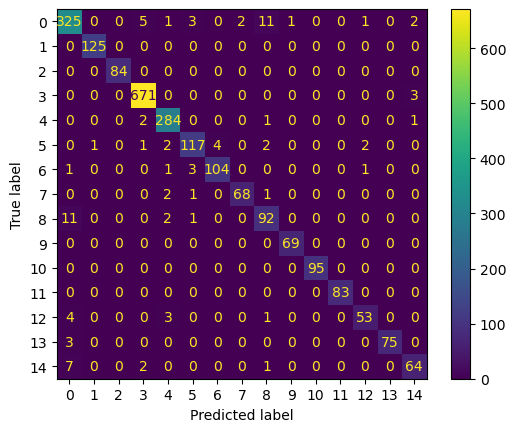

In [80]:
mod_final.fit(X_train, y_train)
final_pred = mod_final.predict(X_test)
print(accuracy_score(y_test, final_pred))
print(classification_report(y_test, final_pred, target_names = target_names))
plot_confusion_matrix(mod_final, X_test, y_test)

0.9562317632346811
              precision    recall  f1-score   support

       Apple       0.91      0.93      0.92       351
      Banana       0.99      0.99      0.99       125
   Carambola       0.95      0.99      0.97        84
       Guava       0.99      0.99      0.99       674
        Kiwi       0.98      0.98      0.98       288
       Mango       0.94      0.87      0.90       129
      Orange       0.95      0.97      0.96       110
       Peach       0.97      0.96      0.97        72
        Pear       0.82      0.88      0.85       106
   Persimmon       0.96      0.97      0.96        69
      Pitaya       1.00      1.00      1.00        95
        Plum       1.00      1.00      1.00        83
 Pomegranate       0.91      0.87      0.89        61
    Tomatoes       0.97      0.95      0.96        78
   Muskmelon       0.91      0.84      0.87        74

    accuracy                           0.96      2399
   macro avg       0.95      0.95      0.95      2399
weighte

/home/dhonicap/miniconda3/envs/titanic/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


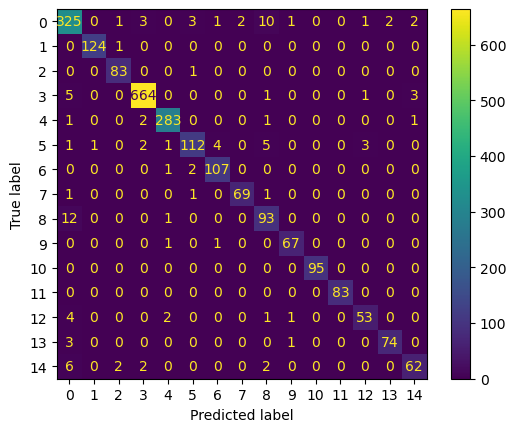

In [75]:
final_mlp.fit(X_train, y_train)
final_pred = final_mlp.predict(X_test)
print(accuracy_score(y_test, final_pred))
print(classification_report(y_test, final_pred, target_names = target_names))
plot_confusion_matrix(final_mlp, X_test, y_test)

0.9453939141308879
              precision    recall  f1-score   support

       Apple       0.90      0.91      0.91       351
      Banana       0.98      0.97      0.98       125
   Carambola       0.98      0.96      0.97        84
       Guava       0.98      0.99      0.99       674
        Kiwi       0.95      0.98      0.97       288
       Mango       0.89      0.88      0.89       129
      Orange       0.89      0.90      0.90       110
       Peach       0.99      0.92      0.95        72
        Pear       0.79      0.80      0.79       106
   Persimmon       0.97      0.91      0.94        69
      Pitaya       1.00      1.00      1.00        95
        Plum       1.00      0.99      0.99        83
 Pomegranate       0.93      0.90      0.92        61
    Tomatoes       1.00      0.94      0.97        78
   Muskmelon       0.90      0.85      0.88        74

    accuracy                           0.95      2399
   macro avg       0.94      0.93      0.93      2399
weighte

/home/dhonicap/miniconda3/envs/titanic/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


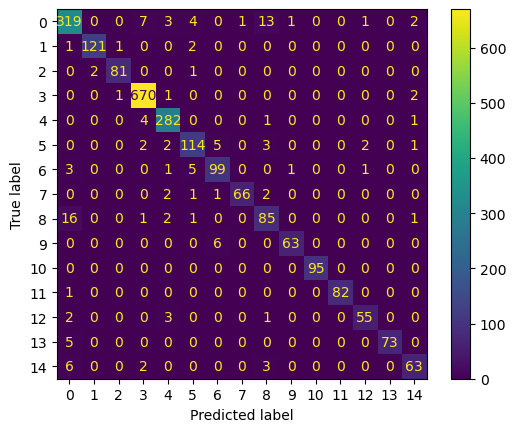

In [76]:
final_xgb.fit(X_train, y_train)
final_pred = final_xgb.predict(X_test)
print(accuracy_score(y_test, final_pred))
print(classification_report(y_test, final_pred, target_names = target_names))
plot_confusion_matrix(final_xgb, X_test, y_test)

0.9420591913297207
              precision    recall  f1-score   support

       Apple       0.90      0.90      0.90       351
      Banana       0.98      0.99      0.99       125
   Carambola       1.00      1.00      1.00        84
       Guava       0.98      1.00      0.99       674
        Kiwi       0.96      0.97      0.96       288
       Mango       0.95      0.87      0.91       129
      Orange       0.90      0.92      0.91       110
       Peach       0.88      0.96      0.92        72
        Pear       0.79      0.77      0.78       106
   Persimmon       0.90      0.93      0.91        69
      Pitaya       0.99      1.00      0.99        95
        Plum       1.00      1.00      1.00        83
 Pomegranate       0.92      0.80      0.86        61
    Tomatoes       0.97      0.96      0.97        78
   Muskmelon       0.84      0.76      0.79        74

    accuracy                           0.94      2399
   macro avg       0.93      0.92      0.93      2399
weighte

/home/dhonicap/miniconda3/envs/titanic/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


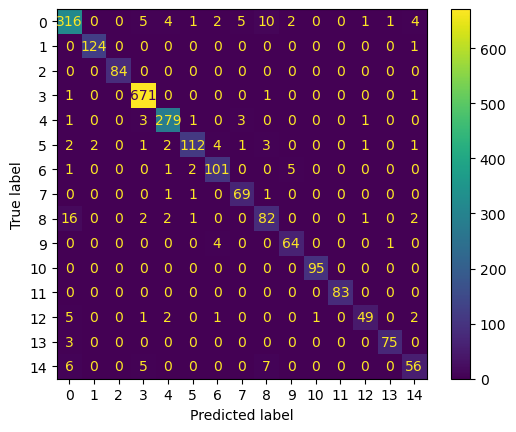

In [77]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
final_pred = knn.predict(X_test)
print(accuracy_score(y_test, final_pred))
print(classification_report(y_test, final_pred, target_names = target_names))
plot_confusion_matrix(knn, X_test, y_test)

In [18]:
pred = []

# TODO: Train a classifier and generate predictions on the test set and put your predictions in pred.
# ...

# Make sure that pred contains a 1-dimensional integer array of class labels for the test set and make sure that
# every integer is in the range 0 through 14. If you have an entry in this array outside of the integer
# range of 0 through 14, it will be assumed to be an error. Also, if your array is not the length of the test
# set that will be assumed to be an error. Specifically, suppose n_mine is the length of the array of integers
# you turn in. If the test set has n_test images (meaning 
# it is an n_test X m matrix), then if your array is less than n_test long (so n_mine < n_test, then any missing 
# images will be assumed to be an error, so there will be n_test - n_mine errors. If your array is longer than 
# n_test images long, so that n_mine > n_test, then we will take the final n_mine - n_test images, whatever
# your predictions are for those images, and assume that those n_mine - n_test images are in error. Bottom line:
# make sure your array is exactly the right length, meaning you should have n_mine == n_test. Meaning,
# the array pred should be a one-dimensional integer array with integers in the 0-14 range
# of length n_mine. You can make sure that pred is of integer type by doing `pred = pred.astype(np.int32)` but
# after you do this, make sure to examine the result to ensure that they are integers in the right range.
#
# Note that the saved text file should have one prediction per ASCII line (this can be done by ensuring that pred 
# is of shape (n_test,) and then simply using np.savetxt).
np.savetxt('test_predictions.txt', pred)
